# Digit Recognizer using Deep Learning

This project is part of the Kaggle competition. You can find more details here: https://www.kaggle.com/c/digit-recognizer#evaluation.
But here is an introduction before I dive in:

## Goal
The goal in this competition is to take an image of a handwritten single digit, and determine what that digit is.
For every ImageId in the test set, you should predict the correct label. 

## Dataset used:
MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.


In [49]:
import numpy as np
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

%matplotlib inline

In [2]:
import sys
print(sys.version)

3.6.4 |Anaconda, Inc.| (default, Mar  9 2018, 07:43:39) [MSC v.1900 64 bit (AMD64)]


# Data description

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. 
Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.
The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.
Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).
For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

In [3]:
from numpy import genfromtxt
train = genfromtxt('data/train.csv', delimiter=',')
test = genfromtxt('data/test.csv', delimiter=',')

## Data visualization
First, lets visualize the data (you can change i to see different train images):

The shape of the image is: (28, 28) 
The number printed is: 8


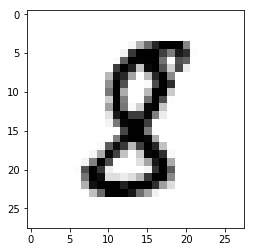

In [4]:
i = 520
img_ex = train[i, 1:].reshape(28,28)
print("The shape of the image is:", img_ex.shape, "\nThe number printed is:", int(train[i,0]))
imgplot = plt.imshow(img_ex,cmap='gray_r')


## Data exploration:
Now I would like to explore the data and get some insight about it.
first let's see how big are my train and test datasets:

In [5]:
print ("The size of the train set is:", len(train[1:,:]))
print ("The size of the test set is:", len(test[1:,:]))

The size of the train set is: 42000
The size of the test set is: 28000


Now I would like to check the train set to see how the different numbers (samples' labels) distribute. 

[1. 0. 1. ... 7. 6. 9.] The shape of Y_train is: (42000,)
The shape of X_train is: (42000, 784)


<function matplotlib.pyplot.show>

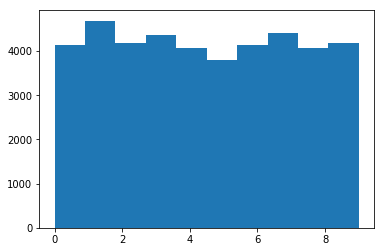

In [29]:
Y_train = train[1:, 0]
X_train = train[1:, 1:]
print(Y_train, "The shape of Y_train is:", Y_train.shape)
print("The shape of X_train is:", X_train.shape)
plt.hist(Y_train, bins=10)
plt.show

It seems like the data is distributed pretty uniformly. Thats GOOD :)

Now I would like to reshape and normalize the train and test data:

In [30]:
#The number of sampels in the train set is m:
m = X_train.shape[0]
#The size of the image is size:
size = X_train.shape[1]
# h is the height of the image (in our case h=w, since our image is a square):
h = int(math.sqrt(size))

#Now I reshape the data:
X_train = X_train.reshape(m,h,h,1)

print("Now X-train shape is:", X_train.shape)

Now X-train shape is: (42000, 28, 28, 1)


In [31]:
# Normalize image vectors
X_train = X_train/255.

In [32]:
print(Y_train)

[1. 0. 1. ... 7. 6. 9.]


In [33]:

# encode Y_train labels to One-hot vectors:
labels = Y_train.reshape(-1).astype(int)
Y_train = np.eye(10)[labels]
print(Y_train.shape, Y_train[0])

(42000, 10) [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


I would like to create at this stage a validation set and a train set from the X_train and Y_train:

In [34]:
from sklearn.cross_validation import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
print (X_train.shape, Y_train.shape)
print (X_val.shape, Y_val.shape)

(33600, 28, 28, 1) (33600, 10)
(8400, 28, 28, 1) (8400, 10)


# The LeNet architecture
![Figure 2: The LeNet architecture consists of two sets of convolutional, activation, and pooling layers, followed by a fully-connected layer, activation, another fully-connected, and finally a softmax classifier (image source).](images/LeNet.png)


The LeNet architecture is an excellent “first architecture” for Convolutional Neural Networks (especially when trained on the MNIST dataset, an image dataset for handwritten digit recognition).
LeNet is small and easy to understand — yet large enough to provide interesting results. Furthermore, the combination of LeNet + MNIST is able to run on the CPU, making it easy for beginners to take their first step in Deep Learning and Convolutional Neural Networks.
In many ways, LeNet + MNIST is the “Hello, World” equivalent of Deep Learning for image classification.
The LeNet architecture consists of the following layers:

### LeNet - Convolutional Neural Network in Python

INPUT => CONV => RELU => POOL => CONV => RELU => POOL => FC => RELU => FC


Note: The original LeNet architecture used TANH  activation functions rather than RELU . The reason we use RELU  here is because it tends to give much better classification accuracy due to a number of nice, desirable properties.

In [35]:
def DigitRecognizerModel(input_shape, classes = 10):
    """
    Implementation of the Lenet model for digit recognition.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    #Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape)
    
    #First layer of conv=> Relu=> Pool:
    # Conv1 layer
    X = Conv2D(20, (5,5), name='conv1')(X_input)
    #Relu1:
    X = Activation('relu')(X)
    # MAXPOOL1
    X = MaxPooling2D(pool_size=(2, 2), strides= (2,2), name='maxpool1')(X)
    
    #Second layer of conv=> Relu=> Pool:
    # Conv2 layer
    X = Conv2D(50, (5,5), name='conv2') (X_input)
    #Relu2:
    X = Activation('relu')(X)
    # MAXPOOL2
    X = MaxPooling2D(pool_size=(2, 2), strides= (2,2), name='maxpool2')(X)
    
    #Set of FC=> Relu layers:
    X = Flatten()(X)
    #X = Dense(600)(X)
    #X = Activation('relu')(X)
    
    #Softmax Classifier:
    output = Dense(classes, activation='softmax', name='fc')(X)
    #output = Activation('softmax', )(X)

    # Create model.
    model = Model(inputs = X_input, outputs = output, name='DigitRecognizerModel')

    return model 

Let's create the model using the function above:

In [36]:
DigitRecognizerModel = DigitRecognizerModel([28, 28, 1])

In [37]:
DigitRecognizerModel.compile(optimizer = "Adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])

In [38]:
DigitRecognizerModel.fit(x = X_train, y = Y_train, epochs = 40, batch_size = 336)

Epoch 1/40
33600/33600 [==============================] - 26s 784us/step - loss: 0.5816 - acc: 0.8420
Epoch 2/40
33600/33600 [==============================] - 27s 806us/step - loss: 0.2052 - acc: 0.9419
Epoch 3/40
33600/33600 [==============================] - 25s 741us/step - loss: 0.1319 - acc: 0.9632
Epoch 4/40
33600/33600 [==============================] - 25s 731us/step - loss: 0.0958 - acc: 0.9734
Epoch 5/40
33600/33600 [==============================] - 26s 761us/step - loss: 0.0782 - acc: 0.9787
Epoch 6/40
33600/33600 [==============================] - 25s 736us/step - loss: 0.0647 - acc: 0.9823
Epoch 7/40
33600/33600 [==============================] - 25s 749us/step - loss: 0.0569 - acc: 0.9842
Epoch 8/40
33600/33600 [==============================] - 25s 754us/step - loss: 0.0518 - acc: 0.9858
Epoch 9/40
33600/33600 [==============================] - 25s 754us/step - loss: 0.0468 - acc: 0.9866
Epoch 10/40
33600/33600 [==============================] - 25s 754us/step - loss: 

In [39]:
preds = DigitRecognizerModel.evaluate(x = X_val, y = Y_val)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

8400/8400 [==============================] - 2s 284us/step

Loss = 0.06130497150397527
Test Accuracy = 0.9840476190476191


# Predictions on the test set:
That's pretty good! Now let's generate the submission file (predictions on the test set):

In [40]:
X_test = test[1:,:]

#The number of sampels in the train set is m:
m = X_test.shape[0]
#The size of the image is size:
size = X_test.shape[1]
# h is the height of the image (in our case h=w, since our image is a square):
h = int(math.sqrt(size))

#Now I reshape the data:
X_test = X_test.reshape(m,h,h,1)

print("Now X-train shape is:", X_test.shape)

Now X-train shape is: (28000, 28, 28, 1)


In [41]:
# Normalize image vectors
X_test = X_test/255.

In [51]:
#Predict results
test_preds = DigitRecognizerModel.predict(x = X_test)
print(test_preds.shape)

(28000, 10)


In [55]:
#Select the index with the maximum probability:
test_labels = np.argmax(test_preds, axis=1)
test_labels = pd.Series(test_labels, name='Label')

In [56]:
submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), test_labels], axis = 1)
submission.to_csv("cnn_submission.csv", index=False)